# Treinar modelo de recuperação

In [1]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

import zipfile

import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

'pt_BR.utf8'

In [ ]:
# sklearn.linear_model
# import LogisticRegression

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path = env)


print("Iniciando carregamento dos dados")
zip_file = os.path.join(dataPath, 'rating_igr.zip')
z = zipfile.ZipFile(zip_file)

Iniciando carregamento dos dados


# 00) Auxiliar

In [4]:
def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

def cria_chave(row):
    return str(row['cda']) + ' - ' + str(row['id_pessoa'])

def paste_intervalo(row):
    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

def ler_bases_exportadas(nome_arquivo):
    z.extract(nome_arquivo)
    df = pd.read_csv(nome_arquivo, sep=',')
    os.remove(nome_arquivo)
    return df

# 01) Importando dados

In [5]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def read_s3(bucket_name, folder_name, file_name):
    file_key_aws = folder_name + file_name
    obj = s3.Bucket(bucket_name).Object(file_key_aws).get()
    df = pd.read_csv(obj['Body'], sep=';')
    return df

In [6]:
dados_contribuinte = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_contribuinte_prime_k4_maxpg_lari.csv')

In [7]:
dados_divida = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_igr_prime_ab0_maxpg_lari.csv')

### Um contribuinte de mercantil em 2 clusters (pq ajustamos os agrupamentos com da_aberto == 0)

In [8]:
dados_contribuinte[dados_contribuinte['id_pessoa'] == '00000b449b8ad90b']

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,valor_tot,valor_pago,qtd_notas_2anos,edificacao,situacao,cpf_cnpj_existe,...,perfil_acessivel,situacao_cobranca,historico_pagamento_em_valor,class_situacao_cobranca,class_contribuinte,da_aberto,class_contribuinte_nome,class_contribuinte_perfil,percentual_pago_cda,class_contribuinte_peso
300748,00000b449b8ad90b,mercantil,2,0,5219.24,0.0,0.0,0.0,SUSPENSO,1,...,0.0,0.0,0.0,INACESSÍVEL,0,0,DEVEDOR PESSIMO,NAO PAGA,0.0,-1.27335
455282,00000b449b8ad90b,mercantil,4,0,27506.70,0.0,0.0,0.0,SUSPENSO,1,...,0.0,0.0,0.0,INACESSÍVEL,0,1,DEVEDOR PESSIMO,NAO PAGA,0.0,-1.27335


In [10]:
num_ocorr_id_pessoa_tipo_divida = dados_contribuinte[['id_pessoa', 'tipo_divida']].value_counts().to_frame()
num_ocorr_id_pessoa_tipo_divida = num_ocorr_id_pessoa_tipo_divida.fillna(0)
#num_ocorr_id_pessoa_tipo_divida[(num_ocorr_id_pessoa_tipo_divida == 2)]
#num_ocorr_id_pessoa_tipo_divida# = num_ocorr_id_pessoa_tipo_divida.rename(columns = {'0': 'num_ocorr'})

## Acompanhar o número de linhas p evitar perdas

In [11]:
dados_contribuinte.shape[0]

734359

In [12]:
dados_contribuinte[dados_contribuinte['da_aberto'] == 0].shape[0]

455147

In [13]:
dados_contribuinte[dados_contribuinte['da_aberto'] == 1].shape[0]

279212

In [14]:
dados_contribuinte[['id_pessoa', 'tipo_divida']].value_counts()

id_pessoa         tipo_divida
00000b449b8ad90b  mercantil      2
8ca3e74b6f4192e7  imovel         2
8ca6269f70a0e942  mercantil      2
8ca5c3b2e1368d54  imovel         2
8ca58d9d4154d47e  imovel         2
                                ..
94a038262410be96  imovel         1
94a06ec4e0fe7d21  imovel         1
94a07e6cf1a5c13f  mercantil      1
94a0b9ed58897cdb  mercantil      1
7fce88a7b3da02f7  mercantil      1
Length: 494695, dtype: int64

In [15]:
dados_contribuinte.loc[dados_contribuinte['da_aberto'] == 0, ['id_pessoa', 'tipo_divida']].value_counts()

id_pessoa         tipo_divida
00000b449b8ad90b  mercantil      1
aabecfebc17fb110  imovel         1
aac06f03864a3f9a  imovel         1
aac03fcaf2a7b7cf  mercantil      1
                  imovel         1
                                ..
557b925505187e2e  mercantil      1
                  imovel         1
557b902fe79d2674  imovel         1
557b8b4dc872fafd  imovel         1
fffff2fc6feb103c  imovel         1
Length: 455147, dtype: int64

In [16]:
dados_contribuinte.loc[dados_contribuinte['da_aberto'] == 1, ['id_pessoa', 'tipo_divida']].value_counts()

id_pessoa         tipo_divida
00000b449b8ad90b  mercantil      1
aa5daf51bfe5dcfb  imovel         1
aa5eda1aafaba02a  mercantil      1
aa5e9cc0411c2e05  mercantil      1
aa5e9120e09f922f  mercantil      1
                                ..
553b88ad4b7be43a  mercantil      1
553b95884c96b982  imovel         1
553bc85dd5fcc0af  imovel         1
553c8e060b440331  mercantil      1
fffff2fc6feb103c  imovel         1
Length: 279212, dtype: int64

In [17]:
dados_divida.shape[0]

1609354

In [18]:
dados_divida['cda'].nunique()

1609354

In [19]:
dados_divida.loc[dados_divida['da_aberto'] == 0, 'cda'].nunique()

1609354

In [ ]:
# # Quantidade de Reparcelamento por CDA
# base_conjunta = ler_bases_exportadas('conjunta.csv')
# reparc_por_cda = base_conjunta[['cda', 'quantidade_reparcelamento']]

# dados_divida = pd.merge(dados_divida, reparc_por_cda, on = 'cda', how = 'left')
# dados_divida

In [ ]:
#dados_divida = ler_bases_exportadas('conjunta_da_aberto.csv')

# 02) Processamento da feature store

In [20]:
print("Variáveis sobre as dívidas:")
print("\n", dados_divida.columns)

Variáveis sobre as dívidas:

 Index(['cda', 'tipo_divida', 'id_pessoa', 'atividade_principal', 'situacao',
       'protesto', 'idade_divida', 'da_aberto', 'valor_total_da', 'valor_pago',
       'valor_aberto', 'dif_tot_pago', 'dif_tot_pago_aberto',
       'percentual_pago_cda', 'percentual_pago_cda_faixas'],
      dtype='object')


In [21]:
print("Variáveis dos contribuintes:")
print("\n", dados_contribuinte.columns)

Variáveis dos contribuintes:

 Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
       'cpf_cnpj_existe', 'endereco_existe', 'perfil_acessivel',
       'situacao_cobranca', 'historico_pagamento_em_valor',
       'class_situacao_cobranca', 'class_contribuinte', 'da_aberto',
       'class_contribuinte_nome', 'class_contribuinte_perfil',
       'percentual_pago_cda', 'class_contribuinte_peso'],
      dtype='object')


In [22]:
# Filtrando variáveis de interesse para a modelagem
df_divida = dados_divida[['cda', 
                          'tipo_divida',
                          'id_pessoa', 
                          'da_aberto',
                          'percentual_pago_cda', 
                          'valor_total_da', 
                          'idade_divida'#, 
                          #'quantidade_reparcelamento' 
                          ]] 

In [23]:
df_divida.shape[0]

1609354

In [24]:
dados_contribuinte_da_ab_0 = dados_contribuinte[dados_contribuinte['da_aberto'] == 0]

In [25]:
dados_contribuinte_da_ab_0.shape[0]

455147

In [26]:
df_contribuinte = dados_contribuinte_da_ab_0[['id_pessoa', 
                                      'tipo_divida',
                                      'num_dist_cda', 
                                      'quantidade_reparcelamento',
                                      #'historico_pagamento_em_qtd',
                                       'historico_pagamento_em_valor',
                                       'situacao_cobranca',
                                       'class_contribuinte_peso']]
#df_contribuinte = df_contribuinte.rename(columns = {'quantidade_reparcelamento':'total_reparc_contrib'})

In [27]:
df_contribuinte.shape[0]

455147

# Mudando o historico dos 1ª dívida

In [28]:
dados_contribuinte.columns

Index(['id_pessoa', 'tipo_divida', 'num_dist_cda', 'quantidade_reparcelamento',
       'valor_tot', 'valor_pago', 'qtd_notas_2anos', 'edificacao', 'situacao',
       'cpf_cnpj_existe', 'endereco_existe', 'perfil_acessivel',
       'situacao_cobranca', 'historico_pagamento_em_valor',
       'class_situacao_cobranca', 'class_contribuinte', 'da_aberto',
       'class_contribuinte_nome', 'class_contribuinte_perfil',
       'percentual_pago_cda', 'class_contribuinte_peso'],
      dtype='object')

In [37]:
q075 = dados_contribuinte.groupby(['class_contribuinte', 'class_contribuinte_nome'])['historico_pagamento_em_valor'].quantile(.75).to_frame().reset_index()
q075_bom = q075.loc[q075['class_contribuinte_nome'] == 'DEVEDOR BOM', 'historico_pagamento_em_valor']
q075_bom

1    0.484834
Name: historico_pagamento_em_valor, dtype: float64

### Imputando 'historico_pagamento_em_valor' dos 1ª dívida como 0 quantil 0.75 do BOM DEVEDOR

#### São 74.134 construibuintes com esse perfil 

In [40]:
df_contribuinte[(df_contribuinte['num_dist_cda'] == 1) & (df_contribuinte['historico_pagamento_em_valor'] < 0.484834)]

,id_pessoa,tipo_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte_peso
101659,4a2a9e7f2449075b,imovel,1,2,0.484762,4.0,0.10483
101661,b62b48996dd0137d,mercantil,1,2,0.484731,3.0,0.10483
101677,dbb2673dea4e9ac0,mercantil,1,2,0.484585,0.0,0.10483
101703,fcafa84207675274,imovel,1,2,0.484389,4.0,0.10483
101714,d822f4ff3eb1d142,imovel,1,2,0.484262,4.0,0.10483
...,...,...,...,...,...,...,...
455127,70dfa0dd50acdc81,imovel,1,0,0.000000,4.0,0.10483
455135,70e836b105bf5957,mercantil,1,0,0.000000,3.0,0.10483
455137,70e7b7e331f1a65f,mercantil,1,0,0.000000,0.0,0.10483
455143,70e6b402b1909b3e,mercantil,1,0,0.000000,0.0,0.10483


In [41]:
df_contribuinte.loc[(df_contribuinte['num_dist_cda'] == 1) & (df_contribuinte['historico_pagamento_em_valor'] < 0.484834), 'historico_pagamento_em_valor'] = 0.484834

In [42]:
# Trazendo dados de parcelas
#df_divida = pd.merge(df_divida, base_parcelas, 
#         on = ['cda', 'id_pessoa'], how = 'left')

df_contribuinte['quantidade_reparcelamento'] = df_contribuinte['quantidade_reparcelamento'].fillna(0)

In [43]:
# Juntar informacoes de 'divida' e 'contribuinte'
#df = pd.merge(left =df_divida, right=df_contribuinte, left_on='id_pessoa', right_on='id_pessoa')

df = pd.merge(df_divida, df_contribuinte, on=['id_pessoa', 'tipo_divida'], how = 'left')
df.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'da_aberto', 'percentual_pago_cda',
       'valor_total_da', 'idade_divida', 'num_dist_cda',
       'quantidade_reparcelamento', 'historico_pagamento_em_valor',
       'situacao_cobranca', 'class_contribuinte_peso'],
      dtype='object')

In [53]:
df_divida.shape[0]

1609354

In [54]:
# Métricas p acompanhar
num_cda_01 = df['cda'].nunique() # hj: 1.608.610 # antes: 2.415.779
num_pessoa_01 = df['id_pessoa'].nunique() # hj: 396.691  # antes: 424.210
vlr_da_01 = df['valor_total_da'].sum() # 'R$ 17.911.603.296,66'

In [55]:
num_cda_01

1609354

In [56]:
num_pessoa_01

396792

In [58]:
formatar_moeda(vlr_da_01)

'R$ 11.763.979.704,63'

### Valor Monetário dos dados de treino por tipo de dívida

In [60]:
df_prop_estoque = df.groupby(['tipo_divida'])['valor_total_da'].sum().to_frame().reset_index()
estoque_total = df_prop_estoque['valor_total_da'].sum()
df_prop_estoque['perc_da'] = np.round(df_prop_estoque['valor_total_da']/estoque_total, 5)


df_prop_estoque['valor_total_da'] = df_prop_estoque['valor_total_da'].apply(formatar_moeda)
df_prop_estoque

,tipo_divida,valor_total_da,perc_da
0,imovel,"R$ 5.555.069.129,02",0.47221
1,mercantil,"R$ 6.208.910.575,61",0.52779


In [61]:
df.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'da_aberto', 'percentual_pago_cda',
       'valor_total_da', 'idade_divida', 'num_dist_cda',
       'quantidade_reparcelamento', 'historico_pagamento_em_valor',
       'situacao_cobranca', 'class_contribuinte_peso'],
      dtype='object')

In [62]:
data_percentil = {
    'inf': [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1],
    'sup': [0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
}

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)
df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)

# Define the bins and labels for groups
igr_bins = [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
igr_labels = df_cut_percentil['intervalo']

df['percentual_pago_cda_faixas'] = pd.cut(df['percentual_pago_cda'],
                                bins = igr_bins,
                                labels = igr_labels,
                                right = False)

In [63]:
df_metrics = df.groupby('percentual_pago_cda_faixas')['percentual_pago_cda_faixas'].count().to_frame()
total = df_metrics['percentual_pago_cda_faixas'].sum()  
df_metrics['total'] = total
df_metrics['perc'] = np.round(df_metrics['percentual_pago_cda_faixas']/total, 4)
df_metrics

,percentual_pago_cda_faixas,total,perc
percentual_pago_cda_faixas,,,
"[0.0, 0.01)",994029,1609354,0.6177
"[0.01, 0.25)",157574,1609354,0.0979
"[0.25, 0.5)",101210,1609354,0.0629
"[0.5, 0.75)",57879,1609354,0.0360
"[0.75, 0.99)",2788,1609354,0.0017
"[0.99, 1.0)",3,1609354,0.0000
"[1.0, 1.01)",295871,1609354,0.1838


# Filtrando os últimos 10 anos

In [64]:
df.shape[0]

1609354

In [65]:
# CDAs que vamos treinar
da_aberto_0 = df[df['da_aberto'] == 0]
da_aberto_0.shape[0]

1609354

In [66]:
# Filtrando apenas dados recentes para treinamento
df = da_aberto_0.query("idade_divida < 10")

In [67]:
df.shape[0] # 10 anos: 1.546.507 # 15 anos: 2.061.060

898809

In [68]:
df_metrics2 = df.groupby('percentual_pago_cda_faixas')['percentual_pago_cda_faixas'].count().to_frame()
total2 = df_metrics2['percentual_pago_cda_faixas'].sum()  
df_metrics2['perc'] = np.round(df_metrics2['percentual_pago_cda_faixas']/total2, 4)
df_metrics2

,percentual_pago_cda_faixas,perc
percentual_pago_cda_faixas,,
"[0.0, 0.01)",576388,0.6413
"[0.01, 0.25)",63445,0.0706
"[0.25, 0.5)",34825,0.0387
"[0.5, 0.75)",36872,0.0410
"[0.75, 0.99)",1276,0.0014
"[0.99, 1.0)",0,0.0000
"[1.0, 1.01)",186003,0.2069


### Filtrando p os últimos 10 anos: 15% dos dados entre 0 e 1

In [69]:
# Estoque considerando os últimos 10 anos
est_10anos = df['valor_total_da'].sum()
est_10anos = locale.currency(est_10anos, grouping=True)
est_10anos # 'R$ 5.992.946.539,56'

'R$ 3.428.559.249,74'

In [ ]:
# print("Informações sobre o dataframe:\n")
# df.info()

# print("\nEstatísticas descritivas:")
# df.describe().T

In [ ]:
# # Para retirar variáveis que não serão usadas no modelo:
# # Vou criar uma chave auxiliar - just in case

# df['chave_aux'] = df.apply(cria_chave, axis = 1)
# # Definir a coluna 'chave_aux' como índice
# df.set_index('chave_aux', inplace=True)
# df

In [70]:
df.columns

Index(['cda', 'tipo_divida', 'id_pessoa', 'da_aberto', 'percentual_pago_cda',
       'valor_total_da', 'idade_divida', 'num_dist_cda',
       'quantidade_reparcelamento', 'historico_pagamento_em_valor',
       'situacao_cobranca', 'class_contribuinte_peso',
       'percentual_pago_cda_faixas'],
      dtype='object')

In [71]:
# Retirando variáveis que não serão usadas no modelo
df_feature_store = df.drop(columns=['da_aberto', 'percentual_pago_cda_faixas'])
df_feature_store = df_feature_store.set_index(['cda', 'tipo_divida', 'id_pessoa'])

In [72]:
df_feature_store.isnull().sum()

percentual_pago_cda             0
valor_total_da                  0
idade_divida                    0
num_dist_cda                    0
quantidade_reparcelamento       0
historico_pagamento_em_valor    0
situacao_cobranca               0
class_contribuinte_peso         0
dtype: int64

# 03) Visualizando a variável target

In [73]:
matriz_correlacao = df_feature_store.corr()

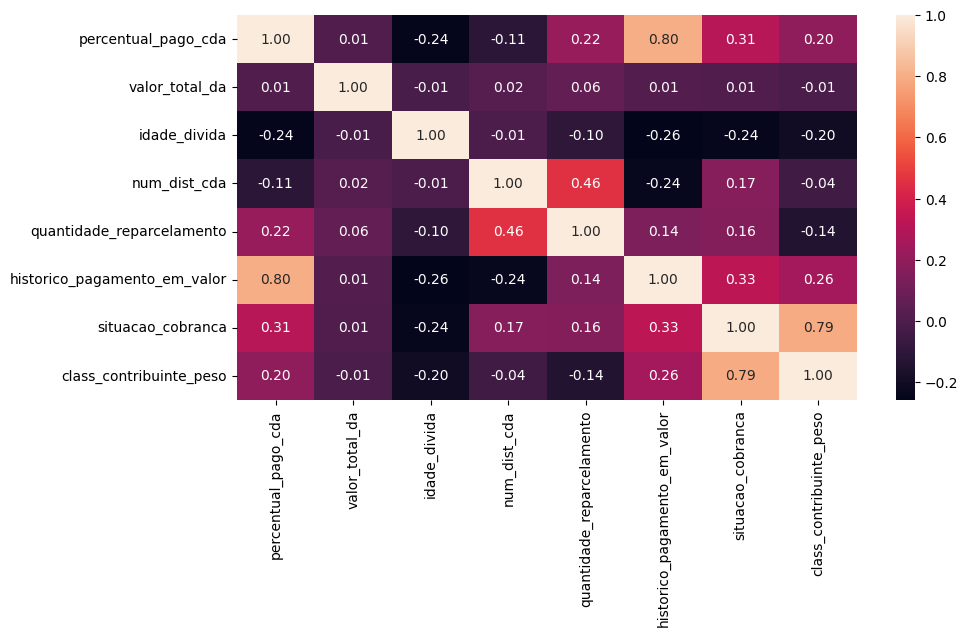

In [74]:
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

# 04) Definindo pipeline de treinamento dos modelos

In [75]:
seed = 1337 # Semente fixando a aleatoridade dos experimentos

In [76]:
df_feature_store['percentual_pago_cda'].mean()

0.2560105111661003

In [77]:
y = df_feature_store['percentual_pago_cda']
x = df_feature_store.drop(columns=['percentual_pago_cda'])

In [78]:
x.columns

Index(['valor_total_da', 'idade_divida', 'num_dist_cda',
       'quantidade_reparcelamento', 'historico_pagamento_em_valor',
       'situacao_cobranca', 'class_contribuinte_peso'],
      dtype='object')

In [79]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=seed, test_size=0.3)

In [80]:
X_train.shape[0]

629166

In [81]:
def roda_pipeline(algoritmo_normalizador, algoritmo_regressao, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([('scaler', algoritmo_normalizador), ('regressor', algoritmo_regressao)])
    pipeline.fit(X_train, y_train)

    previsoes = pipeline.predict(X_test)

    r2 = r2_score(y_test, previsoes)
    mse = mean_squared_error(y_test, previsoes)
    
    print("\nModelo treinado:", str(algoritmo_regressao))
    print("R2 ->", r2)
    print("MSE ->", mse)

In [82]:
biblioteca_modelos = {
    'dummy': DummyRegressor(), # Dados dummy - Usado para baseline
    'random_forest': RandomForestRegressor(random_state=seed)
}

pipeline_modelos = ['dummy','random_forest']

# 05) Executando o experimento de treinamento do modelo

In [83]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritmo_normalizador= StandardScaler(),
        algoritmo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -8.704964986616659e-07
MSE -> 0.16530379931407047

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.82905829888375
MSE -> 0.028257288057856073


In [ ]:
# for modelos in pipeline_modelos:
#     roda_pipeline(
#         algoritmo_normalizador= MinMaxScaler(),
#         algoritmo_regressao= biblioteca_modelos.get(modelos), 
#         X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
#         )

In [ ]:
# for modelos in pipeline_modelos:
#     roda_pipeline(
#         algoritmo_normalizador= RobustScaler(),
#         algoritmo_regressao= biblioteca_modelos.get(modelos), 
#         X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
#     )

**Conclusão:** 
- Adotar StandardScaler

# 06) Realizando previsões com o melhor modelo

In [84]:
normalizador = StandardScaler() #RobustScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)

colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [85]:
x_norm = df_normalizado

In [86]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y, random_state=seed, test_size=0.3)

In [87]:
best_model = RandomForestRegressor(random_state=seed)
best_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1337)

In [88]:
predict_test = best_model.predict(X_test)

r2 = r2_score(y_test, predict_test)
mse = mean_squared_error(y_test, predict_test)

print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("MSE ->", mse)

Métricas de validação do modelo:
R2 -> 0.8290803687268671
MSE -> 0.028253639832114333


In [89]:
best_model.get_params() # Parâmetros utilizados

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1337,
 'verbose': 0,
 'warm_start': False}

In [90]:
variaveis_preditoras = best_model.feature_names_in_
importancia_variaveis = best_model.feature_importances_

print("Variáveis preditoras:")
print('\n', variaveis_preditoras)

Variáveis preditoras:

 ['valor_total_da' 'idade_divida' 'num_dist_cda'
 'quantidade_reparcelamento' 'historico_pagamento_em_valor'
 'situacao_cobranca' 'class_contribuinte_peso']


In [91]:
dados_features = {
    'features': variaveis_preditoras,
    'importancia': importancia_variaveis
}
matriz_importancia = pd.DataFrame(dados_features).sort_values('importancia', ascending=False).reset_index(drop='index')
matriz_importancia

,features,importancia
0,historico_pagamento_em_valor,0.747077
1,valor_total_da,0.140993
2,num_dist_cda,0.040038
3,idade_divida,0.031802
4,quantidade_reparcelamento,0.027238
5,situacao_cobranca,0.007804
6,class_contribuinte_peso,0.005049


In [92]:
# Realizando predições para avaliações do modelo

previsoes_norm = best_model.predict(x_norm)

In [93]:
df_feature_store

,,,percentual_pago_cda,valor_total_da,idade_divida,num_dist_cda,quantidade_reparcelamento,historico_pagamento_em_valor,situacao_cobranca,class_contribuinte_peso
cda,tipo_divida,id_pessoa,,,,,,,,
0000521b64bf28c8e52281a70553db461,imovel,b5df816e1786f0a3,0.00000,490.83,7.0,8,0,0.000000,4.0,1.56033
000057f68f7b77276b3a8e268c80aedf1,imovel,e3df827c83c5efa8,0.00000,1148.06,5.0,14,9,0.282706,4.0,-1.01883
0000662885c684004bd01ecb8277da0b2,mercantil,bac1362812257f05,0.00000,2894.57,9.0,5,4,0.271914,0.0,-1.27335
0000681a0944cefb6b3a8e268c80aedf1,imovel,47d6248500cb7b7d,0.00000,513.48,4.0,10,0,0.000000,4.0,1.56033
00007af008add2c7e52281a70553db461,imovel,d22c7618647dcf14,0.00000,930.47,9.0,8,0,0.000000,0.0,-1.27335
...,...,...,...,...,...,...,...,...,...,...
ffffd120a8f3f2799fcacff532cf50c41,imovel,934532c6c448a899,0.00000,802.85,9.0,8,0,0.000000,4.0,1.56033
ffffd79d8aa612ac9fcacff532cf50c41,imovel,c6b16a1235d987d3,1.00000,26104.42,1.0,2,1,1.000000,4.0,1.56033
ffffd79d8aa612ac9fcacff532cf50c42,mercantil,cc5afb41f6fbc367,0.18519,1431.77,1.0,3,2,0.234058,0.0,-1.27335


In [94]:
# Gerando resíduos da predição (observado - previsão)
df_feature_store['y_predict'] = previsoes_norm
df_feature_store['residuos'] =  df_feature_store['percentual_pago_cda'] - df_feature_store['y_predict']

In [95]:
df_feature_store['percentual_pago_cda'].describe()

count    898809.000000
mean          0.256011
std           0.406663
min           0.000000
25%           0.000000
50%           0.000000
75%           0.494184
max           1.000000
Name: percentual_pago_cda, dtype: float64

In [96]:
df_feature_store['y_predict'].describe()

count    898809.000000
mean          0.256301
std           0.380881
min           0.000000
25%           0.000000
50%           0.000000
75%           0.513506
max           1.000000
Name: y_predict, dtype: float64

In [97]:
resid = df_feature_store[['y_predict', 'percentual_pago_cda', 'residuos']]
resid = resid.sort_values(by = 'residuos', ascending = False)
resid_not0 = resid[resid['y_predict'] != 0]
resid_not0_not1 = resid_not0[resid_not0['y_predict'] != 1]
resid_not0_not1

,,,y_predict,percentual_pago_cda,residuos
cda,tipo_divida,id_pessoa,,,
b57f0bedd67ff13b7c8fa7a67092eaab1,imovel,acc1c99386aebb19,0.000422,1.0,0.999578
7069f0eae1b208234bd01ecb8277da0bE,mercantil,638f7b9526dc7db3,0.000473,1.0,0.999527
16d56fb88adc9d8e18565e26094f06ee1,imovel,fbf3775cbf651b0c,0.000989,1.0,0.999011
c47e15f9d56966476b3a8e268c80aedf1,imovel,3774cdc850fa5021,0.001110,1.0,0.998890
a64aa1733e317bb64bd01ecb8277da0b1,imovel,a76661b73267ac39,0.001180,1.0,0.998820
...,...,...,...,...,...
05661f2542fb597e9fcacff532cf50c41,imovel,14f85bc5f818e8e8,0.990000,0.0,-0.990000
6395c52f852bcbc018565e26094f06ee1,imovel,a273069b667ce1a4,0.990000,0.0,-0.990000
22e835433de136b718565e26094f06ee1,imovel,3e5c12fddab8f43c,0.990000,0.0,-0.990000


In [98]:
data_percentil = {
    'inf': [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75],
    'sup': [-0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
}
[-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)
df_cut_percentil 

,inf,sup,intervalo
0,-1.00,-0.75,"[-1.0, -0.75)"
1,-0.75,-0.50,"[-0.75, -0.5)"
2,-0.50,-0.25,"[-0.5, -0.25)"
3,-0.25,-0.20,"[-0.25, -0.2)"
4,-0.20,-0.15,"[-0.2, -0.15)"
5,-0.15,-0.10,"[-0.15, -0.1)"
6,-0.10,-0.05,"[-0.1, -0.05)"
7,-0.05,0.00,"[-0.05, 0.0)"
8,0.00,0.05,"[0.0, 0.05)"
9,0.05,0.10,"[0.05, 0.1)"


In [99]:
# Define the bins and labels for groups
igr_bins = [-1, -0.75, -0.5, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]
igr_labels = df_cut_percentil['intervalo']

resid['resid_faixas'] = pd.cut(resid['residuos'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
df_summary_residuos = resid.groupby('resid_faixas')['resid_faixas'].count().to_frame()
total = df_summary_residuos['resid_faixas'].sum()
df_summary_residuos['perc'] = np.round(df_summary_residuos['resid_faixas']/total, 5)
df_summary_residuos  

,resid_faixas,perc
resid_faixas,,
"[-1.0, -0.75)",1051,0.00117
"[-0.75, -0.5)",2990,0.00333
"[-0.5, -0.25)",13015,0.01448
"[-0.25, -0.2)",7573,0.00843
"[-0.2, -0.15)",11472,0.01276
"[-0.15, -0.1)",19613,0.02182
"[-0.1, -0.05)",35290,0.03926
"[-0.05, 0.0)",100557,0.11188
"[0.0, 0.05)",625592,0.69603


In [100]:
#df_summary_residuos = resid.groupby('y_faixas')['y_faixas'].count().to_frame()#.reset_index()
df_summary_residuos = df_summary_residuos.rename(columns = {'resid_faixas':'freq'})
df_summary_residuos = df_summary_residuos.reset_index()
df_summary_residuos

,resid_faixas,freq,perc
0,"[-1.0, -0.75)",1051,0.00117
1,"[-0.75, -0.5)",2990,0.00333
2,"[-0.5, -0.25)",13015,0.01448
3,"[-0.25, -0.2)",7573,0.00843
4,"[-0.2, -0.15)",11472,0.01276
5,"[-0.15, -0.1)",19613,0.02182
6,"[-0.1, -0.05)",35290,0.03926
7,"[-0.05, 0.0)",100557,0.11188
8,"[0.0, 0.05)",625592,0.69603
9,"[0.05, 0.1)",26017,0.02895


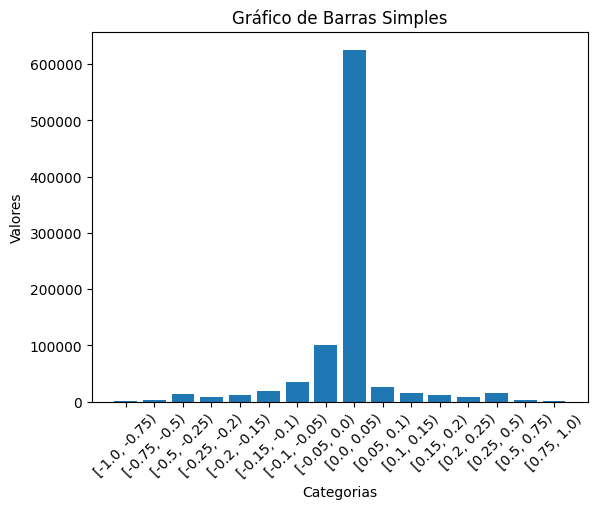

In [101]:
# import matplotlib.pyplot as plt

# # Dados para o gráfico de barras
categorias = df_summary_residuos['resid_faixas']
valores = df_summary_residuos['freq']

# # Criar o gráfico de barras
plt.bar(categorias, valores)

# # Adicionar rótulos ao gráfico
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Simples')

plt.xticks(rotation=45)

# # Exibir o gráfico
plt.show()

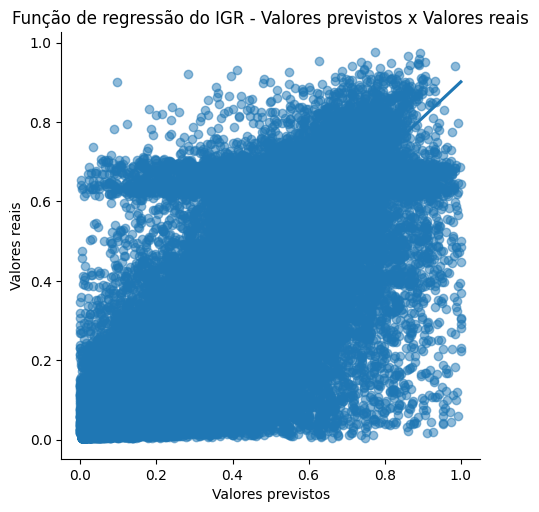

In [102]:
# Todos os pontos
df_regressao = df_feature_store.query("percentual_pago_cda != 1").query("percentual_pago_cda != 0")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

In [103]:
resid['residuos'].describe()

count    898809.000000
mean         -0.000291
std           0.106117
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: residuos, dtype: float64

In [104]:
resid['residuos'].std()

0.10611733967227648

In [ ]:
# Amostras
df_regressao = resid.sample(n=140000)

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()


# Atenção, Larissa

### Calcular um tamanho de amostra n para amostrar os resíduos

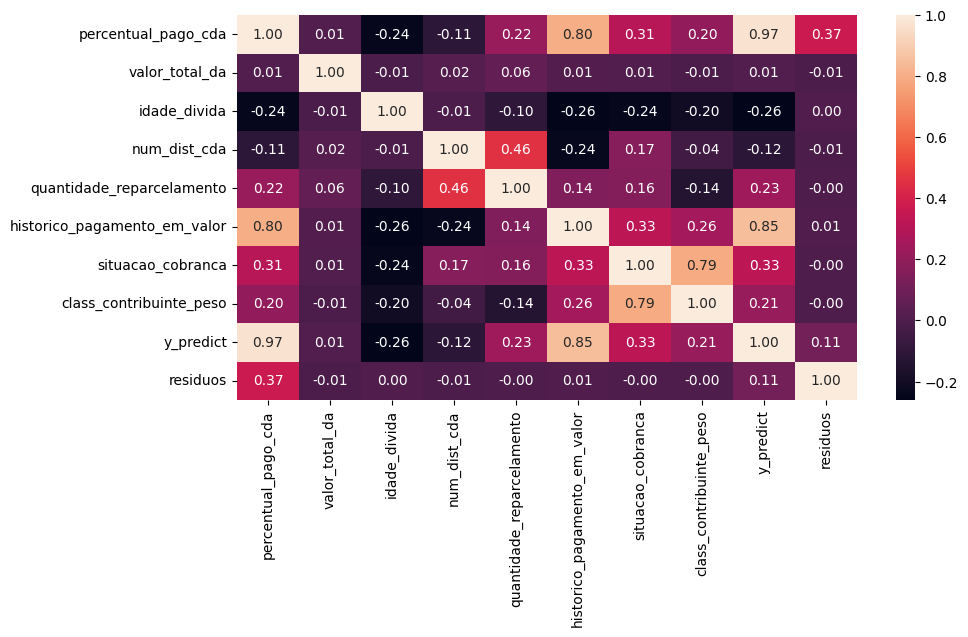

In [105]:
matriz_corr_regressao = df_feature_store.corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_corr_regressao, annot = True, fmt = ".2f")
plt.show()

In [106]:
df_feature_store['residuos'].describe()

count    898809.000000
mean         -0.000291
std           0.106117
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: residuos, dtype: float64

In [107]:
data_percentil = {
    'inf': [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1],
    'sup': [0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
}

# Creating a DataFrame from the dictionary
df_cut_percentil = pd.DataFrame(data_percentil)

df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)

# Define the bins and labels for groups
igr_bins = [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
igr_labels = df_cut_percentil['intervalo']

resid['ypred_faixas'] = pd.cut(resid['y_predict'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)
                            
resid['y_faixas'] = pd.cut(resid['percentual_pago_cda'], 
                                bins = igr_bins, 
                                labels = igr_labels, 
                                right = False)

# Criar a tabela de contingência
contingency_table = pd.crosstab(resid['y_faixas'], resid['ypred_faixas'])
contingency_table   

ypred_faixas,"[0.0, 0.01)","[0.01, 0.25)","[0.25, 0.5)","[0.5, 0.75)","[0.75, 0.99)","[0.99, 1.0)","[1.0, 1.01)"
y_faixas,,,,,,,
"[0.0, 0.01)",498829,65792,8413,2341,984,14,15
"[0.01, 0.25)",294,50747,10904,1278,218,2,2
"[0.25, 0.5)",14,2474,24850,6891,583,6,7
"[0.5, 0.75)",4,429,3769,30376,2287,5,2
"[0.75, 0.99)",0,12,67,674,522,1,0
"[1.0, 1.01)",37,1481,3587,13393,62417,5066,100022


# 07) Salvando o melhor modelo

In [108]:
def salva_modelo_serializado(nome_modelo_serializado, modelo):
    sav_best_model = open(nome_modelo_serializado, 'wb')
    pickle.dump(modelo, sav_best_model)
    sav_best_model.close()

    pathModelo = modelsPath+"\\"+os.path.join(nome_modelo_serializado)
    shutil.move(os.path.abspath(nome_modelo_serializado), pathModelo)

In [109]:
salva_modelo_serializado("modeloDA-igr-divida-prime_maxpg_lari.pkl", best_model)